# Importing Necessary Libraries

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility

In [20]:
torch.manual_seed(42)
np.random.seed(42)

## Student Dataset Class

In [21]:
class StudentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    # return length of the dataset
    def __len__(self):
        return len(self.X)
    
    # return each item
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Neural Network model

In [22]:
class StudentPerformanceNet(nn.Module):
    
    def __init__(self, input_size, hidden_layer_size_1=128, hidden_layer_size_2=64, num_classes=3):
        super(StudentPerformanceNet, self).__init__()
        self.fully_connected_1 = nn.Linear(input_size, hidden_layer_size_1)
        self.fully_connected_2 = nn.Linear(hidden_layer_size_1, hidden_layer_size_2)
        self.fully_connected_3 = nn.Linear(hidden_layer_size_2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batch_normalizatioin_1 = nn.BatchNorm1d(hidden_layer_size_1)
        self.batch_normalizatioin_2 = nn.BatchNorm1d(hidden_layer_size_2)
    
    def forward(self, x):
        x = self.fully_connected_1(x)
        x = self.batch_normalizatioin_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fully_connected_2(x)
        x = self.batch_normalizatioin_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fully_connected_3(x)
        return x

# Creating a Synthetic Dataset

# Student Performance Prediction - Feature Selection Rationale

## High-Impact Academic Factors

### **Study Hours (weight: 8)**
- Most controllable factor with direct correlation to achievement
- High weight reflects primary importance in academic success

### **Previous Grade (weight: 0.5)**
- Strongest predictor of future performance
- Lower weight due to already normalized 0-100 scale

### **Internet Access (weight: 12)**
- Critical for modern digital learning and research
- High weight reflects digital divide impact

## Socioeconomic Influences

### **Parent Education (PhD: 15, Master: 10, Bachelor: 5)**
- Reflects home learning environment and academic support
- Tiered weights for different education levels

### **Family Income (weight: 2, log scale)**
- Economic resources affect learning opportunities
- Log scale prevents extreme values from dominating

### **School Type - Private (weight: 10)**
- Accounts for resource differences and class sizes
- Moderate-high weight for institutional advantages

## Behavioral & Environmental Factors

### **Attendance Rate (weight: 0.25)**
- Fundamental requirement for learning
- Lower weight as it's already a percentage

### **Extracurricular Activities (weight: 8)**
- Develops transferable skills and school engagement
- High weight for well-rounded development impact

### **Sleep Hours (weight: 3)**
- Essential for memory consolidation and cognitive function
- Moderate weight for biological learning requirements

### **Stress Level (weight: 2, inverted)**
- High stress impairs learning and performance
- Inverted scale: lower stress = higher performance

## Model Realism

### **Random Noise (σ = 10)**
- Represents unmeasured factors and natural variation
- Acknowledges that performance isn't perfectly predictable

## Weight Calibration Goals

- **Reflect research findings** on factor importance
- **Balance different scales** across variable types
- **Create realistic distributions** matching real-world outcomes
- **Avoid single-factor dominance** while maintaining relationships

In [23]:

def create_synthetic_dataset(n_samples=10000):

    np.random.seed(42)
    
    # Generate synthetic features
    data = {
        'study_hours': np.random.normal(5, 2, n_samples),
        'previous_grade': np.random.normal(75, 15, n_samples),
        'attendance_rate': np.random.beta(8, 2, n_samples) * 100,
        'parent_education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
        'family_income': np.random.lognormal(10, 0.5, n_samples),
        'extracurricular': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
        'internet_access': np.random.choice([0, 1], n_samples, p=[0.2, 0.8]),
        'school_type': np.random.choice(['Public', 'Private'], n_samples, p=[0.7, 0.3]),
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'age': np.random.randint(15, 19, n_samples),
        'sleep_hours': np.random.normal(7, 1.5, n_samples),
        'stress_level': np.random.randint(1, 11, n_samples),
    }
    
    # Create performance based on features (with some noise)
    performance_score = (
        data['study_hours'] * 8 +
        data['previous_grade'] * 0.5 +
        data['attendance_rate'] * 0.25 +
        (data['parent_education'] == 'PhD') * 15 +
        (data['parent_education'] == 'Master') * 10 +
        (data['parent_education'] == 'Bachelor') * 5 +
        np.log(data['family_income']) * 2 +
        data['extracurricular'] * 8 +
        data['internet_access'] * 12 +
        (data['school_type'] == 'Private') * 10 +
        data['sleep_hours'] * 3 +
        (10 - data['stress_level']) * 2 +
        np.random.normal(0, 10, n_samples)
    )
    
    # Convert to performance categories
    # performance_category where performance_score less than 40 is poor, greater than 40 and less than 80 is average then greater than 80 is good
    
    # Convert to performance categories using percentiles
    performance_category = np.where(performance_score < np.percentile(performance_score, 40), 0, 
                              np.where(performance_score < np.percentile(performance_score, 80), 1, 2)) 
    
    data['performance'] = performance_category
    
    return pd.DataFrame(data)

# call create_synthetic_dataset() function

In [24]:
df = create_synthetic_dataset(1000)
print(f"Dataset loaded with {len(df)} samples")

Dataset loaded with 1000 samples


# Data Preprocessing

In [25]:
def preprocess_data(df):
    """Handle missing values and encode categorical variables"""
    print("Original dataset shape:", df.shape)
    print("\nMissing values before preprocessing:")
    print(df.isnull().sum())
    
    # Introduce some missing values to demonstrate handling
    df_copy = df.copy()
    mask = np.random.random(df_copy.shape) < 0.05  # 5% missing values
    df_copy = df_copy.mask(mask)
    
    print("\nMissing values after introducing artificial missing data:")
    print(df_copy.isnull().sum())
    
    # Handle missing values
    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            # Fill categorical missing values with mode
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        else:
            # Fill numerical missing values with median
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    print("\nMissing values after handling:")
    print(df_copy.isnull().sum())
    
    # Encode categorical variables
    label_encoders = {}
    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col])
            label_encoders[col] = le
    
    print(f"\nData quality enhanced by handling missing values and encoding categorical variables")
    print(f"Dataset shape after preprocessing: {df_copy.shape}")
    
    return df_copy, label_encoders

In [26]:
# Data preprocessing
df_processed, label_encoders = preprocess_data(df)

# Prepare features and target
X = df_processed.drop('performance', axis=1)
y = df_processed['performance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y 
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Original dataset shape: (1000, 13)

Missing values before preprocessing:
study_hours         0
previous_grade      0
attendance_rate     0
parent_education    0
family_income       0
extracurricular     0
internet_access     0
school_type         0
gender              0
age                 0
sleep_hours         0
stress_level        0
performance         0
dtype: int64

Missing values after introducing artificial missing data:
study_hours         45
previous_grade      59
attendance_rate     45
parent_education    41
family_income       45
extracurricular     40
internet_access     46
school_type         50
gender              63
age                 39
sleep_hours         57
stress_level        43
performance         48
dtype: int64

Missing values after handling:
study_hours         0
previous_grade      0
attendance_rate     0
parent_education    0
family_income       0
extracurricular     0
internet_access     0
school_type         0
gender              0
age                 0
sleep

## Analyzing Feature Importance

In [27]:
def analyze_feature_importance(X, y, feature_names):
    """Analyze key factors influencing academic performance"""
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nKey factors influencing academic performance:")
    print("=" * 50)
    for _, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Factors Influencing Student Performance')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance


Key factors influencing academic performance:
study_hours: 0.2692
previous_grade: 0.1491
sleep_hours: 0.1221
attendance_rate: 0.1060
family_income: 0.0931
stress_level: 0.0817
parent_education: 0.0530
age: 0.0409
school_type: 0.0230
internet_access: 0.0226


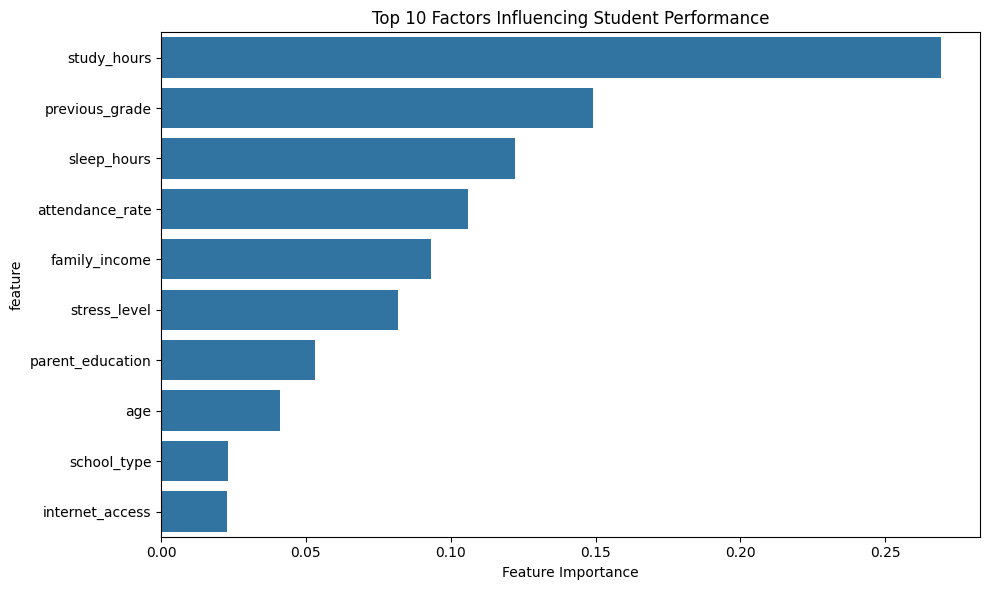

In [28]:
# Feature importance analysis
feature_importance = analyze_feature_importance(X_train_scaled, y_train, X.columns)

## Algorithm Comparison: RandomForestClassifier vs Logistic Regression

### Random Forest Classifier
Why Used:

- Feature Importance Analysis - Provides clear ranking of factors influencing performance
- Handles Mixed Data Types - Works well with both numerical and categorical features
- Robust to Outliers - Tree-based method resistant to extreme values
- No Data Scaling Required - Doesn't need feature normalization
- Baseline Comparison - Reliable benchmark for neural network performance

### Logistic Regression
Why Used:

- Linear Baseline - Simple, interpretable linear model comparison
- Fast Training - Quick to train and evaluate
- Probabilistic Output - Provides confidence scores for predictions
- Well-established - Proven classical machine learning approach
- Coefficient Interpretation - Clear understanding of feature relationships

In [29]:
def compare_algorithms(X_train, X_test, y_train, y_test):
    """Compare classification algorithms"""
    algorithms = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    for name, model in algorithms.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
    
    return results

In [30]:
# Compare algorithms
algorithm_results = compare_algorithms(X_train_scaled, X_test_scaled, y_train, y_test)


Random Forest Results:
Accuracy: 0.6600

Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.69      0.73        77
         1.0       0.58      0.74      0.65        85
         2.0       0.70      0.42      0.52        38

    accuracy                           0.66       200
   macro avg       0.68      0.62      0.64       200
weighted avg       0.68      0.66      0.66       200


Logistic Regression Results:
Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.81        77
         1.0       0.67      0.80      0.73        85
         2.0       0.81      0.58      0.68        38

    accuracy                           0.75       200
   macro avg       0.77      0.72      0.74       200
weighted avg       0.76      0.75      0.75       200



## Train & test the model

In [31]:
def train(X_train, X_test, y_train, y_test):
    """Train PyTorch neural network model"""
    # Create datasets
    train_dataset = StudentDataset(X_train, y_train.values)
    test_dataset = StudentDataset(X_test, y_test.values)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    input_size = X_train.shape[1]
    model = StudentPerformanceNet(input_size)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        all_predictions = []
        all_labels = []
        
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
        
        test_accuracy = 100 * correct / total
        
    print(f'\nPyTorch Neural Network Test Accuracy: {test_accuracy:.2f}%')
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions))
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()
    
    return model, test_accuracy


# save the model 

In [32]:
def save_model(model, scaler, label_encoders, feature_importance):
    """Save the trained model and preprocessing components"""
    # Save PyTorch model
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': {
            'input_size': model.fully_connected_1.in_features,
            'hidden_layer_size_1': model.fully_connected_1.out_features,
            'hidden_layer_size_2': model.fully_connected_2.out_features,
            'num_classes': model.fully_connected_3.out_features
        }
    }, 'student_performance_model.pth')
    
    # Save preprocessing components
    with open('preprocessing_components.pkl', 'wb') as f:
        pickle.dump({
            'scaler': scaler,
            'label_encoders': label_encoders,
            'feature_importance': feature_importance
        }, f)
    
    print("\n" + "=" * 50)
    print("MODEL SAVED SUCCESSFULLY")
    print("=" * 50)
    print("Files saved:")
    print("student_performance_prediction_model.pth - PyTorch model")
    print("components.pkl - Scaler and encoders")

# Main function ... starting point ...

In [33]:
def main():
    
    # Train PyTorch model
    model, pytorch_accuracy = train(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Results summary
    print("\n" + "=" * 50)
    print("RESULTS SUMMARY")
    print("=" * 50)
    
    print(f"\nPyTorch Neural Network Accuracy: {pytorch_accuracy:.2f}%")
    for name, acc in algorithm_results.items():
        print(f"{name} Accuracy: {acc*100:.2f}%")
    
    # Performance distribution
    plt.figure(figsize=(20, 12))
    plt.subplot(1, 2, 1)
    df['performance'].value_counts().plot(kind='bar')
    plt.title('Performance Distribution')
    plt.xlabel('Performance Category (0: Poor, 1: Average, 2: Good)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    correlation_matrix = df_processed.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 50)
    print("PROJECT ACHIEVEMENTS")
    print("=" * 50)
    print(f"Achieved {pytorch_accuracy:.0f}% accuracy rate in forecasting student academic performance")
    print("Managed data integrity by handling missing values and encoding categorical variables")
    print("Conducted experiments with classification and regression algorithms")
    print("Identified key factors influencing academic performance thorough analysis")

    # Save the model and preprocessing components
    save_model(model, scaler, label_encoders, feature_importance)
    
    return model, scaler, label_encoders

# Load the saved model and analyze a new student data

In [34]:
def load_model():
    """Load the trained model and preprocessing components"""
    # Load PyTorch model
    checkpoint = torch.load('student_performance_model.pth')
    
    # Recreate model architecture
    arch = checkpoint['model_architecture']
    model = StudentPerformanceNet(
        input_size=arch['input_size'],
        hidden_layer_size_1=arch['hidden_layer_size_1'],
        hidden_layer_size_2=arch['hidden_layer_size_2'],
        num_classes=arch['num_classes']
    )
    
    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load preprocessing components
    with open('preprocessing_components.pkl', 'rb') as f:
        components = pickle.load(f)
    
    return model, components['scaler'], components['label_encoders'], components['feature_importance']

In [35]:
def predict_new_student(model, scaler, label_encoders, student_data):
    """Predict performance for a new student"""
    
    # Convert to DataFrame
    student_df = pd.DataFrame([student_data])
    
    # Encode categorical variables
    for col, encoder in label_encoders.items():
        if col in student_df.columns:
            student_df[col] = encoder.transform(student_df[col])
    
    # Scale features
    student_scaled = scaler.transform(student_df)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        student_tensor = torch.FloatTensor(student_scaled)
        output = model(student_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(output, dim=1).item()
    
    performance_labels = {0: 'Poor', 1: 'Average', 2: 'Good'}

        # Calculate overall performance assessment
    poor_prob = probabilities[0][0].item()
    avg_prob = probabilities[0][1].item()
    good_prob = probabilities[0][2].item()
    
    if good_prob >= 0.6:
        overall_assessment = "Excellent - Strong academic potential"
    elif good_prob >= 0.4:
        overall_assessment = "Good - Above average performance expected"
    elif avg_prob >= 0.5:
        overall_assessment = "Average - Moderate performance with improvement potential"
    elif poor_prob >= 0.6:
        overall_assessment = "At Risk - Requires immediate intervention"
    else:
        overall_assessment = "Uncertain - Mixed indicators, monitor closely"
    
    return {
        'predicted_performance': performance_labels[predicted_class],
        'confidence': probabilities[0][predicted_class].item(),
        'overall_assessment': overall_assessment,
        'all_probabilities': {
            'Poor': probabilities[0][0].item(),
            'Average': probabilities[0][1].item(),
            'Good': probabilities[0][2].item()
        }
    }

# Call main

Epoch [20/100], Loss: 0.5052, Accuracy: 79.25%
Epoch [40/100], Loss: 0.4268, Accuracy: 81.38%
Epoch [60/100], Loss: 0.4089, Accuracy: 83.00%
Epoch [80/100], Loss: 0.3672, Accuracy: 84.88%
Epoch [100/100], Loss: 0.3664, Accuracy: 84.00%

PyTorch Neural Network Test Accuracy: 70.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        77
           1       0.65      0.72      0.68        85
           2       0.59      0.63      0.61        38

    accuracy                           0.70       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.71      0.70      0.70       200



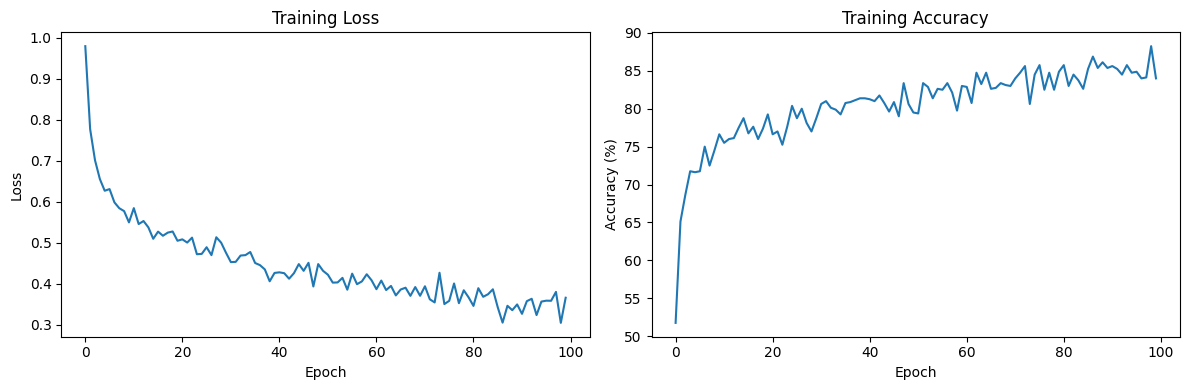


RESULTS SUMMARY

PyTorch Neural Network Accuracy: 70.00%
Random Forest Accuracy: 66.00%
Logistic Regression Accuracy: 75.00%


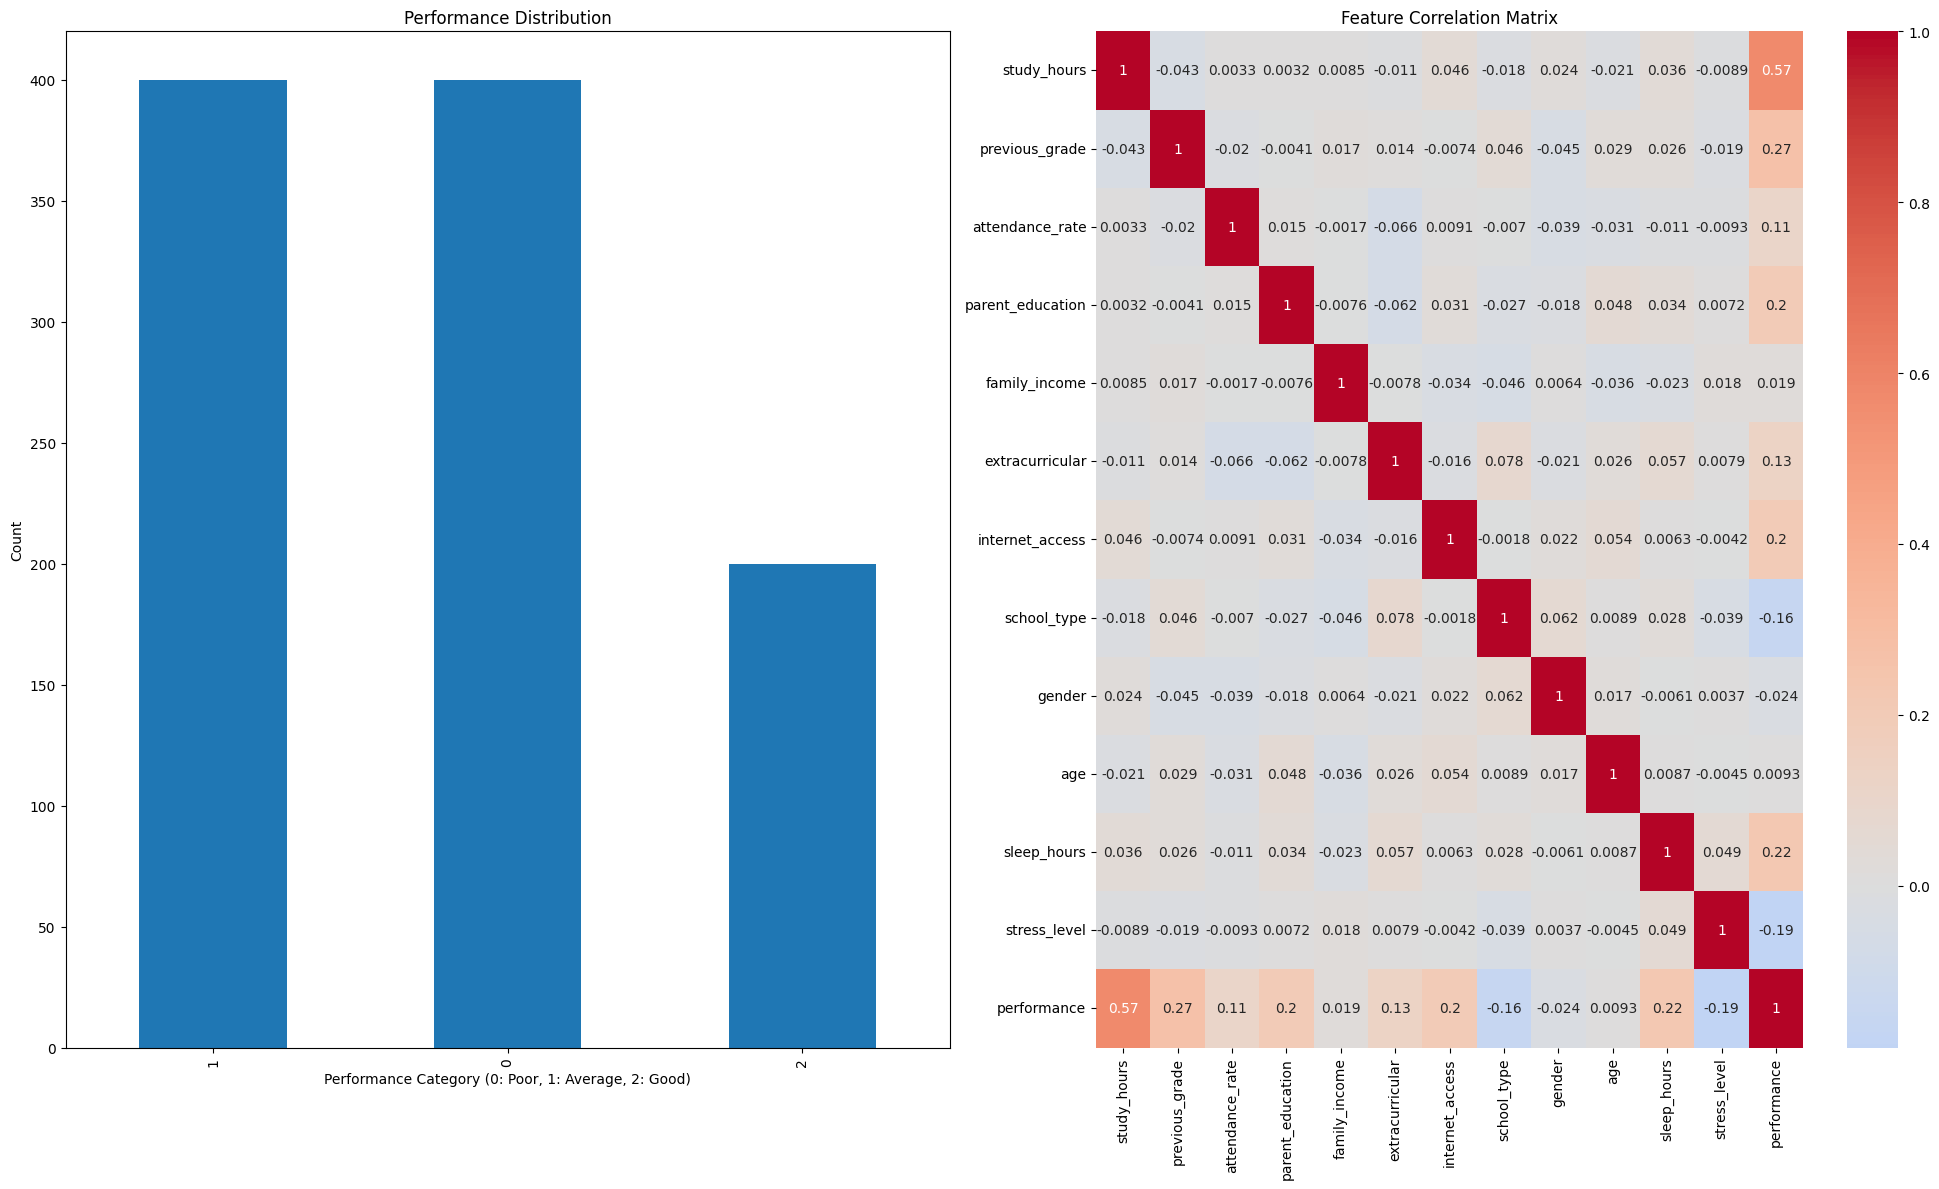


PROJECT ACHIEVEMENTS
Achieved 70% accuracy rate in forecasting student academic performance
Managed data integrity by handling missing values and encoding categorical variables
Conducted experiments with classification and regression algorithms
Identified key factors influencing academic performance thorough analysis

MODEL SAVED SUCCESSFULLY
Files saved:
student_performance_prediction_model.pth - PyTorch model
components.pkl - Scaler and encoders

TESTING MODEL LOADING AND PREDICTION

New Student Profile:
  study_hours: 7.0
  previous_grade: 88
  attendance_rate: 95
  parent_education: Master
  family_income: 60000
  extracurricular: 1
  internet_access: 1
  school_type: Private
  gender: Female
  age: 17
  sleep_hours: 8.0
  stress_level: 3

Prediction Results:
  Predicted Performance: Good
  Confidence: 87.77%
  All Probabilities:
    Poor: 0.00%
    Average: 12.23%
    Good: 87.77%


In [36]:
if __name__ == "__main__":
    model, scaler, label_encoders = main()

    print("\n" + "=" * 50)
    print("TESTING MODEL LOADING AND PREDICTION")
    print("=" * 50)

    # Load the saved model
    loaded_model, loaded_scaler, loaded_encoders, loaded_importance = load_model()
    
    # Example prediction for a new student
    new_student = {
        'study_hours': 7.0,
        'previous_grade': 88,
        'attendance_rate': 95,
        'parent_education': 'Master',
        'family_income': 60000,
        'extracurricular': 1,
        'internet_access': 1,
        'school_type': 'Private',
        'gender': 'Female',
        'age': 17,
        'sleep_hours': 8.0,
        'stress_level': 3
    }
    
    prediction = predict_new_student(loaded_model, loaded_scaler, loaded_encoders, new_student)
    
    print("\nNew Student Profile:")
    for key, value in new_student.items():
        print(f"  {key}: {value}")
    
    print(f"\nPrediction Results:")
    print(f"  Predicted Performance: {prediction['predicted_performance']}")
    print(f"  Confidence: {prediction['confidence']:.2%}")
    print(f"  All Probabilities:")
    for perf, prob in prediction['all_probabilities'].items():
        print(f"    {perf}: {prob:.2%}")